# AVISO data assimilation with correlated error reduction with 1-step approach

In [1]:
import numpy as np
import scipy
import gsw
import xarray as xr
import cmocean as cmo
from numpy import linalg as LA
from scipy import linalg
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from tqdm import tqdm
from aviso_rossby_wave import skill_matrix, inversion
from aviso_rossby_wave import build_swath, make_error
from aviso_rossby_wave import reverse_vector, forecast_ssh

## Starting Date

In [2]:
day0, day1 = 0, 1 # April 1st, 2017 # day0, day1 =  1856, 1857 July 1st, 2017
start_date = '2016-06-01' ## starting date
n_waves = '450' #number of waves

## Subset 10 degree by 10 degree of ocean

In [3]:
lonidx_west, lonidx_east  =  60, 100
latidx_south, latidx_north = 34, 74

In [4]:
avisso_ds = xr.open_dataset('./aviso_msla_ccs_5d.nc')
SSHA = avisso_ds.msla[latidx_south:latidx_north,lonidx_west:lonidx_east,  :]

In [5]:
T_time = avisso_ds.time.data[day0:] * 86400 # time in seconds
date_time = avisso_ds.date_time.data[day0:]
date_time[0], avisso_ds.msla.shape, SSHA.shape # longtitude, latitude, time

(numpy.datetime64('2016-06-01T00:00:00.000000000'),
 (104, 184, 150),
 (40, 40, 150))

In [6]:
ssha_time_mean = SSHA.mean(axis = -1)

In [7]:
SSHA = SSHA - SSHA.mean(axis = -1) - SSHA.mean(axis = 0)

In [8]:
SSHA_masked = np.ma.masked_invalid(SSHA)

In [9]:
ssha_mask = np.ma.getmask(SSHA_masked)

In [10]:
lon, lat = (360 - avisso_ds.lon[lonidx_west:lonidx_east].data) * -1, avisso_ds.lat[latidx_south:latidx_north].data

### Stratification paramters

In [11]:
Phi0 = lat.mean() # central latitude (φ0)
Omega = 7.27e-5 # Ω is the angular speed of the earth
Earth_radius = 6.371e6 / 1e5 # meters to degrees
Beta = 2 * Omega * np.cos(Phi0) / Earth_radius
f0 = 2 * Omega * np.sin(Phi0) #1.0313e-4 # 45 N
g = 9.81 # gravity 

### Inversion with selecetd swath data points

In [12]:
strat_ds = xr.open_dataset('./stratification_sample_ccs.nc')

In [13]:
Psi = strat_ds.Psi.data
MModes = 1
wavespeed = strat_ds.C2[:MModes].data  #np.array([Rm * f0])


### the aviso data is sampled at 5-day intervals

#### Rossby wave estimate

In [14]:
wave_ds = xr.open_dataset('./rossby_wave_estimate_' + start_date +'_' + n_waves + 'waves.nc')

#### Rossby deformation radius

In [15]:
k_n_orig, l_n_orig = wave_ds.k_n.data, wave_ds.l_n.data
amp = wave_ds.Amplitudes.data
time= wave_ds.time.data
MSLA_fwd = wave_ds.MSLA_forward.data
Rm = wave_ds.Rm.data

In [16]:
k_n = k_n_orig.reshape(len(k_n_orig), MModes)
l_n = l_n_orig.reshape(len(l_n_orig), MModes)

In [17]:
MSLA0 = MSLA_fwd[:, :, day0:day1]

In [18]:
skill, SSHA_vector, Iindex, Jindex, Tindex = skill_matrix(MSLA0, Psi, k_n, l_n, MModes, Rm, lon, lat, T_time)
M = skill.size # number of models/waves

100%|████████████████████████████████████████| 450/450 [00:01<00:00, 235.78it/s]


In [19]:
kk, ll = np.meshgrid(k_n, l_n)

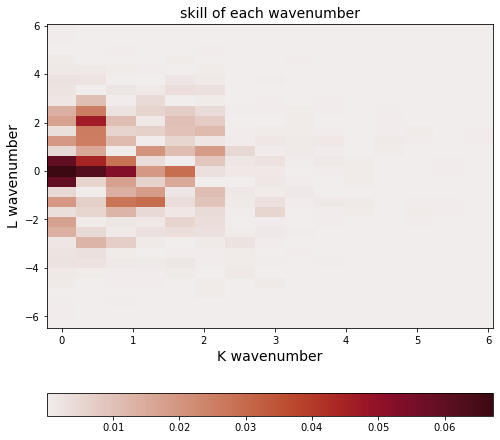

In [20]:
plt.figure(figsize = (8, 8))
plt.pcolor(kk, ll, skill[:, :, 0], cmap = cmo.cm.amp)
plt.xlabel('K wavenumber', fontsize = 14)
plt.ylabel('L wavenumber', fontsize = 14)
plt.colorbar(orientation = 'horizontal')
plt.title('skill of each wavenumber', fontsize = 14)
plt.savefig('./skill_matrix_KLwaves_' + str(M) + '.png')

#### Build basis function H matrix

In [21]:
MModes = 1
H_cos, H_sin = np.zeros([len(SSHA_vector), M]), np.zeros([len(SSHA_vector), M])
H_all = np.zeros([len(SSHA_vector), M * 2])
freq_n = np.zeros([M, MModes])

dlon = lon - lon.mean()
dlat = lat - lat.mean()

count = 0 
for kk in range(len(k_n)):
    for ll in range(len(l_n)):
        for mm in range(MModes):
            freq_n[count, mm] =  -1 * (Beta * k_n[kk]) / (k_n[kk] ** 2 + l_n[ll] ** 2 + Rm ** (-2))
            count += 1
nn = 0 
for kk in range(len(k_n)):
    for ll in range(len(l_n)):
        for mm in range(MModes):
            for count in range(len(Iindex)):
                H_cos[count, nn] = Psi[0, mm] * np.cos(l_n[ll] * dlon[int(Iindex[count])] + k_n[kk] * dlat[int(Jindex[count])] + freq_n[nn] * T_time[int(Tindex[count])])  
                H_sin[count, nn] = Psi[0, mm] * np.sin(l_n[ll] * dlon[int(Iindex[count])] + k_n[kk] * dlat[int(Jindex[count])] + freq_n[nn] * T_time[int(Tindex[count])])
            nn += 1

In [22]:
H_all[:, 0::2] = H_cos 
H_all[:, 1::2] = H_sin

#### build satellite swath

In [23]:
swath_width, x_swath = 6, 20
days = np.arange(day0, day1) # np.array([0, 1]) #range(day0, day1)
xvalid_index, yvalid_index, tindex, yswath_index_left, yswath_index_right, y_mask_left, y_mask_right = build_swath(swath_width, x_swath, days, lon, lat)

#### Add errors to the swaths

In [24]:
alpha_base = 1e-2 # baseline dialation error parameter
alpha_roll = .5e-2 #  np.arange(1, len(day)) # roll error parameter
alpha_timing = .5e-2 # timing error parameter
alpha_phase3, alpha_phase4, alpha_phase5, alpha_phase6 = 4e-2, 3e-2, 2e-2, 1e-2
alpha = np.array([alpha_timing, alpha_roll, alpha_base, alpha_phase3, alpha_phase4, alpha_phase5, alpha_phase6])
timing_err_valid, roll_err_valid, baseline_dilation_err_valid, phase_err_valid, phase_err_left3, phase_err_left4, phase_err_left5, phase_err_left6, xc1_valid, xc2_valid  = make_error(days, alpha, yswath_index_left, yswath_index_right, y_mask_left, y_mask_right)

In [25]:
 phase_err_left3.shape, baseline_dilation_err_valid.shape

((40, 6), (450,))

#### Add white noise 

In [26]:
IND_TIMING = -7
IND_BASELINE = -6
IND_ROLL = -5
IND_PHASE3, IND_PHASE4, IND_PHASE5, IND_PHASE6 = -4, -3, -2, -1

In [27]:
N = len(xvalid_index) # number of valid data points
MSLA_swath = np.zeros(len(xvalid_index))
nx, ny = len(lon), len(lat)
H_v = np.zeros([N, 2 * M + 7]) # M: number of model
IIndex = np.zeros(N) # N: Number of y data
cor_err = np.zeros(N) # Correlated Error N: Number of y data
Y_v = np.zeros(N)
ssh = np.zeros(N)
xc = (swath_width - 1) / 2

for ii in range(N):
    IIndex[ii] = nx * yvalid_index[ii] + xvalid_index[ii]
    cor_err[ii] = timing_err_valid[ii]+ roll_err_valid[ii] + baseline_dilation_err_valid[ii] + phase_err_valid[ii]
    ssh[ii] = MSLA_fwd[xvalid_index[ii], yvalid_index[ii], int(tindex[ii])]
    Y_v[ii] =  cor_err[ii]  + ssh[ii] # + np.random.rand(1)/400
    # timing error = alpha[0] * Xc^0
    H_v[ii, IND_TIMING] = 1 #  alpha_timing, TIMING ERR, distance from nadir Xc
    # roll error = alpha[1] * Xc^1
    H_v[ii, IND_ROLL] = xc1_valid[ii]  # alpha_roll, ROLL ERR, distance from nadir Xc
    # baseline dialation error = alpha[2] * Xc^2
    H_v[ii, IND_BASELINE] = xc2_valid[ii]  # alpha_base, BASELINE DIALATION ERR, distance from nadir Xc 
    # phase error 
    H_neg = np.heaviside(-1 * xc1_valid[ii], 1) #
    H_pos = np.heaviside(xc1_valid[ii], 1) # 
    # print(H_neg, H_pos)
    H_v[ii, IND_PHASE3] = H_neg                 # alpha_phase3 * np.heaviside(xx - xc, 1)
    H_v[ii, IND_PHASE4] = xc1_valid[ii] * H_neg # alpha_phase4 * Xc * np.heaviside(xx - xc, 1)
    H_v[ii, IND_PHASE5] = H_pos                 # alpha_phase5 * np.heaviside(xx + xc, 1)
    H_v[ii, IND_PHASE6] = xc1_valid[ii] * H_pos # alpha_phase6 * np.heaviside(xx + xc, 1)
    for nn in range(M):
        JIndex = 2 * MModes * nn
        H_v[ii, JIndex] = H_cos[IIndex[ii].astype(int), nn]
        H_v[ii, JIndex + 1] = H_sin[IIndex[ii].astype(int), nn]

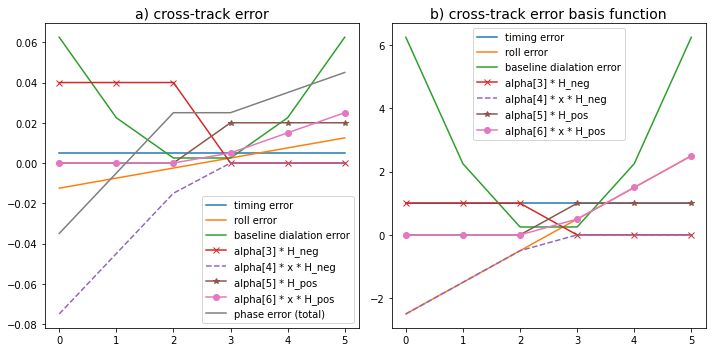

In [28]:
plt.figure(figsize = (10, 5))
plt.subplot(121)
plt.title('a) cross-track error', fontsize = 14)
plt.plot(timing_err_valid[:6], label = 'timing error')
plt.plot(roll_err_valid[:6], label = 'roll error')
plt.plot(baseline_dilation_err_valid[:6], label = 'baseline dialation error')
plt.plot(phase_err_left3[0, :6], '-x', label = 'alpha[3] * H_neg')
plt.plot(phase_err_left4[0, :6], '--', label = 'alpha[4] * x * H_neg')
plt.plot(phase_err_left5[0, :6], '-*', label = 'alpha[5] * H_pos')
plt.plot(phase_err_left6[0, :6], '-o', label = 'alpha[6] * x * H_pos')
plt.plot(phase_err_valid[:6], label = 'phase error (total)')
plt.legend()

plt.subplot(122)
plt.title('b) cross-track error basis function', fontsize = 14)
plt.plot(H_v[:6, IND_TIMING], label = 'timing error')
plt.plot(H_v[:6, IND_ROLL], label = 'roll error')
plt.plot(H_v[:6, IND_BASELINE], label = 'baseline dialation error')
#plt.plot(phase_err_valid[:6], label = 'phase error (total)')
plt.plot(H_v[:6, IND_PHASE3], '-x', label = 'alpha[3] * H_neg')
plt.plot(H_v[:6, IND_PHASE4], '--', label = 'alpha[4] * x * H_neg')
plt.plot(H_v[:6, IND_PHASE5], '-*', label = 'alpha[5] * H_pos')
plt.plot(H_v[:6, IND_PHASE6], '-o', label = 'alpha[6] * x * H_pos')
plt.legend()
plt.tight_layout()

plt.savefig('./cross_track_err_basis_function.png')

### 1-step approach: Solve for amplitudes and errors together

#### signal to noise ratio

In [29]:
counter = 0
exp = 1
alpha_factor = 1e1
kl = np.zeros(2 * M)
P_over_R = np.zeros([2 * M + 7, 2 * M + 7])
P_over_R[IND_TIMING, IND_TIMING] = alpha[IND_TIMING] * alpha_factor #** 2 # timing error
P_over_R[IND_ROLL, IND_ROLL] = alpha[IND_ROLL] ** 2 *  alpha_factor #** 2 # roll error
P_over_R[IND_BASELINE, IND_BASELINE] = alpha[IND_BASELINE]*  alpha_factor #** 2 # baseline dilation error
P_over_R[IND_PHASE3, IND_PHASE3] = alpha[IND_PHASE3] *  alpha_factor # ** 2 # phase error 1
P_over_R[IND_PHASE4, IND_PHASE4] = alpha[IND_PHASE4]* alpha_factor  # ** 2 # phase error 2
P_over_R[IND_PHASE5, IND_PHASE5] = alpha[IND_PHASE5] * alpha_factor # ** 2 # phase error 3
P_over_R[IND_PHASE6, IND_PHASE6] = alpha[IND_PHASE6]*  alpha_factor  # ** 2 # phase error 4

for kk in k_n:
    for ll in l_n:
        kl[counter] = np.sqrt(kk ** 2 + ll ** 2) # wavenumber
        P_over_R[2 * counter, 2 * counter] = kl[counter] ** exp
        P_over_R[2 * counter+ 1, 2 * counter + 1] = kl[counter] ** exp
        counter += 1 

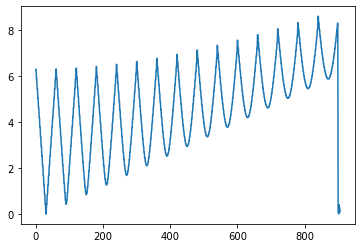

In [30]:
plt.plot(P_over_R.diagonal())

In [31]:
amp_1step, ssh_estimated_swath = inversion(Y_v, H_v, P_over_R)

#### One approach sanity check: fit errors to seven error basis functions

In [32]:
H_v[-7:, -7:].shape, P_over_R[-7:, -7:].shape

((7, 7), (7, 7))

In [33]:
amp_err_only, err_estimated_swath = inversion(cor_err, H_v[:, -7:], P_over_R[-7:, -7:])

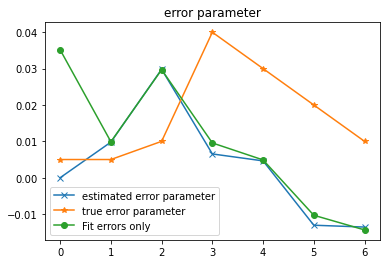

In [34]:
plt.title('error parameter')
plt.plot(amp_1step[-7:], '-x', label = 'estimated error parameter')
plt.plot(alpha, '-*', label = 'true error parameter')
plt.plot(amp_err_only, '-o', label = 'Fit errors only')
plt.legend()

In [35]:
amp_1step[-7:], alpha

(array([ 1.85536272e-12,  9.78906288e-03,  2.98164883e-02,  6.53250773e-03,
         4.62454158e-03, -1.30650155e-02, -1.35754599e-02]),
 array([0.005, 0.005, 0.01 , 0.04 , 0.03 , 0.02 , 0.01 ]))

In [36]:
for ii in range(len(xvalid_index)):
    IIndex[ii] = nx * yvalid_index[ii] + xvalid_index[ii]
    cor_err[ii] = timing_err_valid[ii]+ roll_err_valid[ii] + baseline_dilation_err_valid[ii] + phase_err_valid[ii]
    ssh[ii] = MSLA_fwd[xvalid_index[ii], yvalid_index[ii], int(tindex[ii])]
    Y_v[ii] = ssh[ii] + cor_err[ii] # + np.random.rand(1)/400
    # timing error = alpha[0] * Xc^0
    H_v[ii, IND_TIMING] = 1 
    # roll error = alpha[1] * Xc^1
    H_v[ii, IND_ROLL] = xc1_valid[ii]
    # baseline dialation error = alpha[2] * Xc^2
    H_v[ii, IND_BASELINE] = xc2_valid[ii] 
    # phase error 
    H_neg = np.heaviside(-1 * xc1_valid[ii], 1) 
    H_pos = np.heaviside(xc1_valid[ii], 1) 
    H_v[ii, IND_PHASE3] = H_neg                 
    H_v[ii, IND_PHASE4] = xc1_valid[ii] * H_neg 
    H_v[ii, IND_PHASE5] = H_pos                 
    H_v[ii, IND_PHASE6] = xc1_valid[ii] * H_pos
    
    for mm in range(M):
        JIndex = 2 * MModes * mm
        H_v[ii, JIndex] = H_cos[IIndex[ii].astype(int), mm]
        H_v[ii, JIndex + 1] = H_sin[IIndex[ii].astype(int), mm]

ssh_estimated_swath = np.matmul(H_v, amp_1step) # estimated swath SSH-1 *

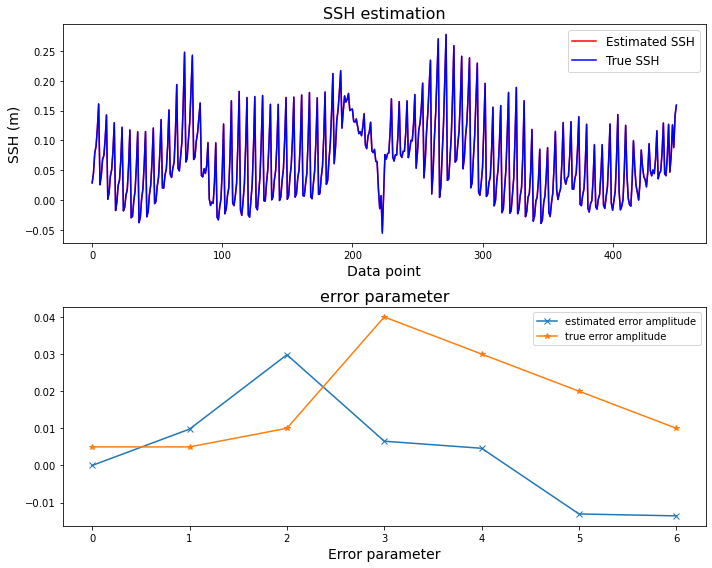

In [37]:
plt.figure(figsize=(10, 8))
plt.subplot(211)
plt.plot(ssh_estimated_swath, 'r', label='Estimated SSH')
plt.plot(Y_v, 'b', label='True SSH')
#plt.xlabel('Distance along swath (km)', fontsize=14)
plt.xlabel('Data point', fontsize=14)
plt.ylabel('SSH (m)', fontsize=14)
plt.title('SSH estimation', fontsize=16)
plt.legend(fontsize=12)
#plt.show()
plt.subplot(212)
plt.title('error parameter', fontsize=16)
plt.plot(amp_1step[-7:], '-x', label = 'estimated error amplitude')
plt.plot(alpha, '-*', label = 'true error amplitude')
plt.xlabel('Error parameter', fontsize=14)
plt.legend()
plt.tight_layout()
plt.savefig('./ssh_err_parameter.png')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


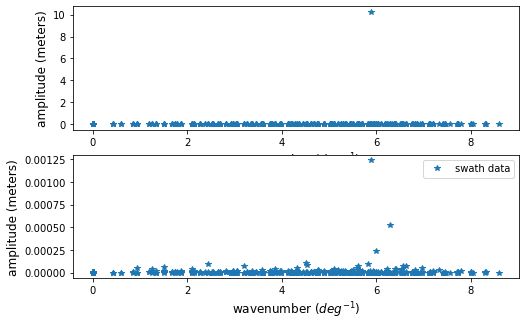

In [38]:
plt.figure(figsize = (8, 5))
plt.subplot(211)
plt.xlabel('wavenumber ($deg^{-1}$)', fontsize = 12)
plt.ylabel('amplitude (meters)', fontsize = 12)
plt.plot(kl, amp_1step[:-7] ** 2  , '*', label = 'true amp')
plt.subplot(212)
plt.legend()

plt.xlabel('wavenumber ($deg^{-1}$)', fontsize = 12)
plt.ylabel('amplitude (meters)', fontsize = 12)
plt.plot(kl, amp ** 2 , '*', label = 'swath data')
plt.legend()

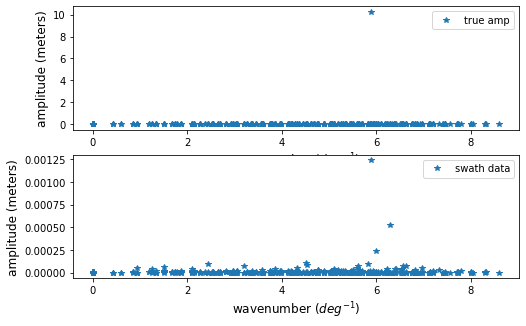

In [39]:
plt.figure(figsize = (8, 5))
plt.subplot(211)
plt.xlabel('wavenumber ($deg^{-1}$)', fontsize = 12)
plt.ylabel('amplitude (meters)', fontsize = 12)
plt.plot(kl, amp_1step[:-7]**2  , '*', label = 'true amp')
plt.legend()

plt.subplot(212)
plt.xlabel('wavenumber ($deg^{-1}$)', fontsize = 12)
plt.ylabel('amplitude (meters)', fontsize = 12)
plt.plot(kl, amp**2 , '*', label = 'swath data')
plt.legend()
#plt.plot(kl, amp, '*') #red spectrum large amp, la

#### True and estimated SSH and Errors

In [40]:
Y_hat = np.matmul(H_v, amp_1step)
err_est = np.matmul(H_v[:, -7:], amp_1step[-7:])
ssh_est = np.matmul(H_v[:, :-7], amp_1step[:-7])
err_map1 = np.zeros([len(lon), len(lat)])
ssh_map1 = np.zeros([len(lon), len(lat)])
ssh_true1 = np.zeros([len(lon), len(lat)])
err_true1 = np.zeros([len(lon), len(lat)])
for ii, idx in enumerate(xvalid_index):
    err_map1[xvalid_index[ii], yvalid_index[ii],] = err_est[ii] 
    ssh_map1[xvalid_index[ii], yvalid_index[ii],]  = ssh_est[ii]
    err_true1[xvalid_index[ii], yvalid_index[ii]] = cor_err[ii]
    ssh_true1[xvalid_index[ii], yvalid_index[ii]] = ssh[ii]

#### Reverse the vectorization on the swaths

In [41]:
ssh_diff1 = np.sqrt(np.mean((ssh_true1 - ssh_map1) ** 2 ))/ np.sqrt(np.mean((ssh_true1) ** 2 ))

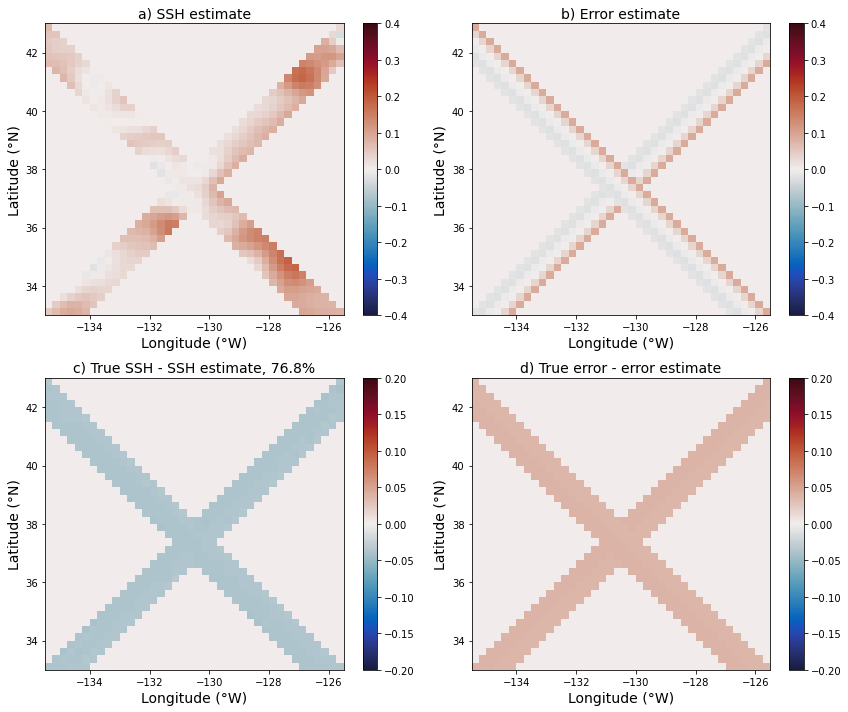

In [42]:
fig = plt.figure(figsize = (12, 10))

plt.subplot(221)
plt.pcolormesh(lon, lat, ssh_map1, vmin = -.4, vmax = .4, cmap = cmo.cm.balance)
plt.colorbar()
plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
plt.title('a) SSH estimate', fontsize = 14)

plt.subplot(222)
plt.pcolormesh(lon, lat, err_map1, cmap = cmo.cm.balance, vmin = -.4, vmax = .4)
plt.colorbar()
plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
plt.title('b) Error estimate', fontsize = 14)

plt.subplot(223)
plt.pcolormesh(lon, lat, ssh_true1 - ssh_map1, cmap = cmo.cm.balance, vmin = -.2, vmax = .2)
plt.colorbar()
plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
plt.title('c) True SSH - SSH estimate, ' + str(ssh_diff1 * 100)[:4] + '%', fontsize = 14)

plt.subplot(224)
plt.pcolormesh(lon, lat, err_true1 - err_map1, cmap = cmo.cm.balance, vmin = -.2, vmax = .2)
plt.colorbar()
plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
plt.title('d) True error - error estimate', fontsize = 14)

plt.tight_layout()
plt.savefig('aviso_ssh_estimate_'+ str(date_time[days])[:10] + '_1step.png', dpi = 300)

#### Make predictions of SSH based on the estimated amplitudes:
#### is the extrapolation skill good?

In [43]:
time_range = 8 ## 8 * 5 = 40 days
SSHA_predicted = np.zeros([time_range, MSLA0[:, :, 0:1].size])
SSHA_true = np.zeros([time_range, MSLA0[:, :, 0:1].size])
variance_explained_inverse = np.zeros(time_range)
MSLA_inverse = np.zeros([MSLA0.shape[0], MSLA0.shape[1], time_range])
for day in range(0, time_range):
    MSLA = MSLA_fwd[:,:,day:day+1] 
    SSHA_predicted[day], SSHA_true[day], variance_explained_inverse[day] = forecast_ssh(day, amp_1step[:-7], MSLA, MModes, k_n, l_n, lon, lat, T_time, Psi, Rm)
    MSLA_inverse[:, :, day:day+1] = reverse_vector(MSLA, SSHA_predicted[day])
    
    plt.figure(figsize = (15, 5))

    plt.subplot(131)
    plt.pcolormesh(lon, lat, MSLA[:, :, 0], cmap = cmo.cm.balance, vmin = -.15, vmax = .15) #MSLA_fwd[:, :, day]
    plt.colorbar()
    plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
    plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
    plt.title('a) AVISO forward model ' + str(date_time[day])[:10], fontsize = 14)

    plt.subplot(132)
    plt.plot(lon[xvalid_index], lat[yvalid_index], 'x', color = 'gray')
    plt.pcolormesh(lon, lat, MSLA_inverse[:, :, day], vmin = -.15, vmax = .15, cmap = cmo.cm.balance)
    plt.colorbar()
    plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
    plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
    plt.title('b) 1-step inversion, swath data', fontsize = 14)

    residual = MSLA[:, :, 0] - MSLA_inverse[:, :, day] 
    plt.subplot(133)
    plt.plot(lon[xvalid_index], lat[yvalid_index], 'x', color = 'gray')
    plt.pcolormesh(lon, lat, residual, cmap = cmo.cm.balance, vmin = -.15, vmax = .15)
    plt.colorbar()
    plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
    plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
    plt.title('c) Residual variance ' + str((1 - variance_explained_inverse[day]) * 100)[:4] + '%', fontsize = 14)
    
    plt.tight_layout()
    plt.close()
    plt.savefig('ssh_1step_' + str(date_time[day])[:10] +'_2_err_' + str(skill.size) + 'waves.png', dpi = 300)
    

<Figure size 432x288 with 0 Axes>

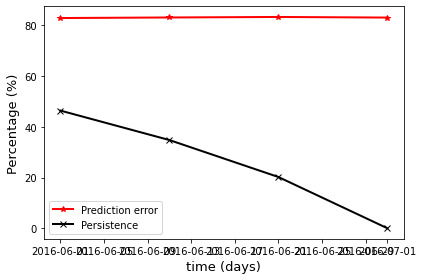

In [44]:
persistence = SSHA.data[:, :, day0:day0+time_range] - SSHA.data[:, :, day0+6:day0+7]
prediction_err = MSLA_inverse[:, :, :time_range] - MSLA_fwd[:, :, :time_range]
rms_persistence = np.zeros(persistence.shape[-1])
rms_prediction_err = np.zeros(prediction_err.shape[-1])
for t in range(persistence.shape[-1]):
    #rms_persistence_err[t] = np.sqrt(np.mean(persistence_err[:, :, t] ** 2)) / np.sqrt(np.mean(SSHA[:, :, 0:1].data ** 2))
    rms_persistence[t] = np.sqrt(np.mean(persistence[:, :, t] ** 2)) / np.sqrt(np.mean(SSHA[:, :, 0:1].data ** 2))
    rms_prediction_err[t] = np.sqrt(np.mean(prediction_err[:, :, t] ** 2)) / np.sqrt(np.mean(SSHA[:, :, t].data ** 2))

#plt.figure(figsize = (10,10))
#plt.subplot(211)
plt.plot(time[:time_range][0::2],  rms_prediction_err[:time_range][0::2] * 100,  
         '-*',linewidth = 2, color = 'r', label = 'Prediction error')

#plt.subplot(212)
plt.plot(time[:time_range][0::2], rms_persistence[:time_range][0::2] * 100,  
         '-x', linewidth = 2, color = 'k', label = 'Persistence' )
#plt.plot(T_time[:time_range][0::2]/86400, np.repeat(100, len(time)),linestyle = '--',  color = 'y')
#plt.xticks(time[:time_range][0::2]/86400, time[:time_range][0::2] - time[0])
plt.ylabel('Percentage (%)', fontsize = 13)
plt.xlabel('time (days)', fontsize = 13)
plt.legend()
plt.tight_layout()
plt.savefig('./prediction_vs_persistence/prediction_err_vs_persistence_' + str(M) + '_waves_2errs.png', dpi = 300)

### One approach sanity check: fit errors to seven error basis functions

#### construct H matrix with only error basis funcstons

In [45]:
count = 0
MSLA_swath = np.zeros(len(xvalid_index))
nx, ny = len(lon), len(lat)
H_v1 = np.zeros([N, 7]) # M: number of model
IIndex = np.zeros(N) # N: Number of y data
Y_v, cor_err, ssh = np.zeros(N), np.zeros(N), np.zeros(N)
for ii in range(len(xvalid_index)):
    #IIndex[ii] = ny * xvalid_index[ii] + yvalid_index[ii]
    IIndex[ii] = nx * yvalid_index[ii] + xvalid_index[ii]
    cor_err[ii] = timing_err_valid[ii]+ roll_err_valid[ii] + baseline_dilation_err_valid[ii] + phase_err_valid[ii]
    ssh[ii] = MSLA_fwd[xvalid_index[ii], yvalid_index[ii], int(tindex[ii])]
    
    # Only fit errors! 
    Y_v[ii] =  cor_err[ii]  #+ ssh[ii]  #
    
    H_v1[ii, IND_TIMING] = 1 # timing error = alpha[0] * X^0 
    H_v1[ii, IND_ROLL] = xc1_valid[ii] # roll error = alpha[1] * X^1
    H_v1[ii, IND_BASELINE] = xc2_valid[ii] # baseline dialation error = alpha[2] * X^2
    H_neg = np.heaviside(-1 * xc1_valid[ii], 1) 
    H_pos = np.heaviside(xc1_valid[ii], 1)
    
    # phase error
    H_v1[ii, IND_PHASE3] = H_neg                 
    H_v1[ii, IND_PHASE4] = xc1_valid[ii] * H_neg 
    H_v1[ii, IND_PHASE5] = H_pos                 
    H_v1[ii, IND_PHASE6] = xc1_valid[ii] * H_pos 

In [46]:
P_over_R1 = np.eye(7, 7)
P_over_R1[IND_TIMING, IND_TIMING] = alpha[IND_TIMING] * alpha_factor #** 2 # timing error
P_over_R1[IND_ROLL, IND_ROLL] = alpha[IND_ROLL] *  alpha_factor #** 2 # roll error
P_over_R1[IND_BASELINE, IND_BASELINE] = alpha[IND_BASELINE]*  alpha_factor #** 2 # baseline dilation error
P_over_R1[IND_PHASE3, IND_PHASE3] = alpha[IND_PHASE3] *  alpha_factor #** 2 # phase error 1
P_over_R1[IND_PHASE4, IND_PHASE4] = alpha[IND_PHASE4]*  alpha_factor  #** 2 # phase error 2
P_over_R1[IND_PHASE5, IND_PHASE5] = alpha[IND_PHASE5] *  alpha_factor #** 2 # phase error 3
P_over_R1[IND_PHASE6, IND_PHASE6] = alpha[IND_PHASE6]*  alpha_factor  #** 2 # phase error 4

In [47]:
HTH = np.matmul(H_v1.T, H_v1)

In [48]:
HRH = HTH + P_over_R1 #0.81 * sigma #, P: uncertainty in model, R: uncertainty in data
D = np.matmul(LA.inv(HRH), H_v1.T)   

In [49]:
amp_err = np.matmul(D, Y_v)
amp_err , alpha

(array([ 0.03510384,  0.00984598,  0.02377641,  0.00954594,  0.01070195,
        -0.01031592, -0.00832943]),
 array([0.005, 0.005, 0.01 , 0.04 , 0.03 , 0.02 , 0.01 ]))

In [50]:
#### test: fit two errors with two error models
amp_2err_2model = np.matmul(D, cor_err)
amp_2err_2model ,  alpha

(array([ 0.03510384,  0.00984598,  0.02377641,  0.00954594,  0.01070195,
        -0.01031592, -0.00832943]),
 array([0.005, 0.005, 0.01 , 0.04 , 0.03 , 0.02 , 0.01 ]))

#### correlated error

In [51]:
#### estimate the correlated error
err_est = np.matmul(H_v1, amp_err)
#err_est

#### SSH + correlated errors - estimated correlated errors

In [52]:
tau_ssh = Y_v - err_est

In [53]:
err_map = np.zeros([len(lon), len(lat)])
ssh_true = np.zeros([len(lon), len(lat)])
ssh_1st_step = np.zeros([len(lon), len(lat)])
err_true = np.zeros([len(lon), len(lat)])
for ii, idx in enumerate(xvalid_index):
    err_map[yvalid_index[ii], xvalid_index[ii]] = err_est[ii] #[Iindex[ii].astype(int)]
    ssh_true[yvalid_index[ii], xvalid_index[ii]] = ssh[ii]
    err_true[yvalid_index[ii], xvalid_index[ii]] = cor_err[ii]
    ssh_1st_step[yvalid_index[ii], xvalid_index[ii]] = tau_ssh[ii]

In [54]:
ssh_diff_1st_step = np.sqrt(np.mean((ssh_true - ssh_1st_step) ** 2 ))/ np.sqrt(np.mean((ssh_true) ** 2 ))
ssh_diff_1st_step , str(ssh_diff_1st_step * 100)[:4] 

(0.9999641090109315, '99.9')

In [55]:
for ii in range(len(xvalid_index)):
    IIndex[ii] = nx * yvalid_index[ii] + xvalid_index[ii]
    cor_err[ii] = timing_err_valid[ii]+ roll_err_valid[ii] + baseline_dilation_err_valid[ii] + phase_err_valid[ii]
    ssh[ii] = MSLA_fwd[xvalid_index[ii], yvalid_index[ii], int(tindex[ii])]
    Y_v[ii] =  cor_err[ii] # + ssh[ii] + # + np.random.rand(1)/400
    H_v1[ii, IND_TIMING] = 1 
    H_v1[ii, IND_BASELINE] = xc1_valid[ii] 
    H_v1[ii, IND_ROLL] = xc2_valid[ii] 
    H_neg = np.heaviside(-1 * xc1_valid[ii], 1) 
    H_pos = np.heaviside(xc1_valid[ii], 1) 
    H_v[ii, IND_PHASE3] = H_neg                 
    H_v[ii, IND_PHASE4] = xc1_valid[ii] * H_neg 
    H_v[ii, IND_PHASE5] = H_pos                 
    H_v[ii, IND_PHASE6] = xc1_valid[ii] * H_pos 
    
    for nn in range(M):
        JIndex = 2 * MModes * nn
        H_v[ii, JIndex] = H_cos[IIndex[ii].astype(int), nn]
        H_v[ii, JIndex + 1] = H_sin[IIndex[ii].astype(int), nn]

#ssh_estimated_swath = np.matmul( H_v1, err_est) # estimated swath SSH

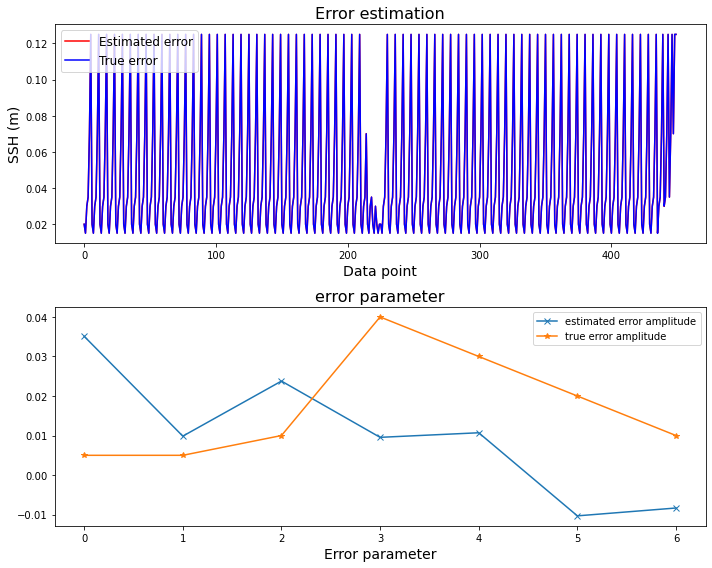

In [56]:
plt.figure(figsize=(10, 8))
plt.subplot(211)
plt.plot(err_est, 'r', label='Estimated error')
plt.plot(Y_v, 'b', label='True error')
#plt.xlabel('Distance along swath (km)', fontsize=14)
plt.xlabel('Data point', fontsize=14)
plt.ylabel('SSH (m)', fontsize=14)
plt.title('Error estimation', fontsize=16)
plt.legend(fontsize=12)
#plt.show()

plt.subplot(212)
plt.title('error parameter', fontsize=16)
plt.plot(amp_err, '-x', label = 'estimated error amplitude')
plt.plot(alpha, '-*', label = 'true error amplitude')
plt.xlabel('Error parameter', fontsize=14)
plt.legend()
plt.tight_layout()
plt.savefig('./ssh_err_parameter.png')

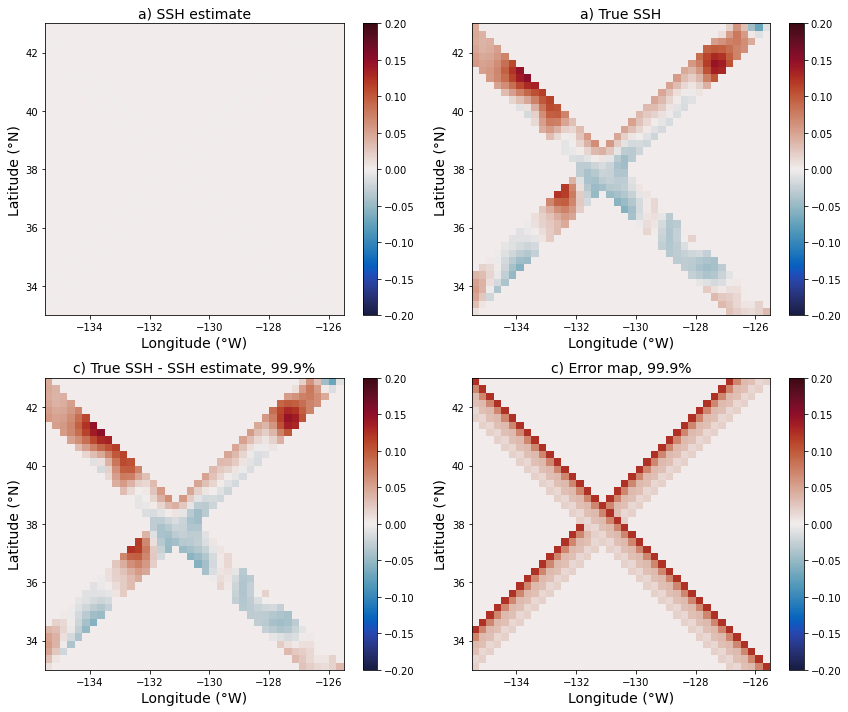

In [57]:
fig = plt.figure(figsize = (12, 10))

plt.subplot(221)
plt.pcolormesh(lon, lat, ssh_1st_step, vmin = -.2, vmax = .2, cmap = cmo.cm.balance)
plt.colorbar()
plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
plt.title('a) SSH estimate', fontsize = 14)


plt.subplot(222)
plt.pcolormesh(lon, lat, ssh_true, vmin = -.2, vmax = .2, cmap = cmo.cm.balance)
plt.colorbar()
plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
plt.title('a) True SSH', fontsize = 14)

plt.subplot(223)
plt.pcolormesh(lon, lat, ssh_true- ssh_1st_step, cmap = cmo.cm.balance, vmin = -.2, vmax = .2)
plt.colorbar()
plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
plt.title('c) True SSH - SSH estimate, ' + str(ssh_diff_1st_step * 100)[:4] + '%', fontsize = 14)


plt.subplot(224)
plt.pcolormesh(lon, lat, err_map, cmap = cmo.cm.balance, vmin = -.2, vmax = .2)
plt.colorbar()
plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
plt.title('c) Error map, ' + str(ssh_diff_1st_step * 100)[:4] + '%', fontsize = 14)

plt.tight_layout()
plt.savefig('aviso_err_map_1st_step'+ str(date_time[day])[:10] +'.png', dpi = 300)

In [58]:
al, ac = yswath_index_left.shape
xc = (ac-1) / 2

# swath 1
xc1_left, xc2_left = np.ma.masked_all(yswath_index_left.shape), np.ma.masked_all(yswath_index_left.shape)
H_neg_left, H_pos_left = np.ma.masked_all(yswath_index_left.shape), np.ma.masked_all(yswath_index_left.shape)